In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import  PorterStemmer

import pickle
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.preprocessing import  LabelEncoder

import re
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
df = pd.read_csv('data/bbc.csv')

In [4]:
df.head(3)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...


In [5]:
df.shape

(2225, 2)

In [6]:
def eng_clean(document):
    text = re.sub(r'http\S+', ' ', document, flags=re.MULTILINE)
    text = BeautifulSoup(text, "lxml").text

    for sign in ['\n', '\x0c']:
        text = text.replace(sign, ' ')

    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = ' '.join([i for i in text.split()])

    return text.lower().strip()

In [7]:
stemmer = PorterStemmer()
stop_stem = set([stemmer.stem(word) for word in stopwords.words('english')])

tfidf = TfidfVectorizer(lowercase = False,
                        ngram_range = (1, 1),
                        min_df = 2,
                        max_df = 0.9)

In [8]:
start = time.time()

df['text'] = df['text'].astype(str)
end1 = time.time()
print("to string: ", end1 - start)

df['text'] = df['text'].apply(lambda x : eng_clean(x))

end2 = time.time()
print("clean: ", end2 - end1)

df['text'] = df['text'].apply(lambda x : [word for word in x.split() if len(word) > 1])
end3 = time.time()
print("tokenize: ", end3 - end2)

dog = stemmer.stem('dogs')

df['text'] = df['text'].apply(lambda x : [stemmer.stem(word) for word in x])
end4 = time.time()
print("stem: ", end4 - end3)

df['text'] = df['text'].apply(lambda x : [word for word in x if word not in stop_stem])
end5 = time.time()
print("remove stopwords: ", end5 - end4)

df['text'] = df['text'].apply(lambda x : " ".join(x))

end = time.time()
print("total time: ", end - start)

to string:  0.000997781753540039
clean:  1.713277816772461
tokenize:  0.16197824478149414
stem:  24.709347248077393
remove stopwords:  0.14189457893371582
total time:  26.76380181312561


In [9]:
df

,category,text
0,tech,futur hand viewer home theatr system plasma hi...
1,business,worldcom boss left book alon former worldcom b...
2,sport,tiger wari farrel gambl leicest say rush make ...
3,sport,yead face newcastl cup premiership side newcas...
4,entertainment,ocean twelv raid box offic ocean twelv crime c...
...,...,...
2220,business,car pull retail figur retail sale fell januari...
2221,politics,kilroy unveil immigr polici chatshow host robe...
2222,entertainment,rem announc new glasgow concert band rem annou...
2223,politics,polit squabbl snowbal becom commonplac argu bl...


In [10]:
encoder = LabelEncoder()
encoder.fit(df['category'])
keys = encoder.classes_
values = encoder.transform(encoder.classes_)
cat_to_int = dict(zip(keys, values))
int_to_cat = dict(zip(values, keys))

print(cat_to_int)
print(int_to_cat)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


In [11]:
df['category'] = encoder.transform(df['category'])

In [12]:
df

,category,text
0,4,futur hand viewer home theatr system plasma hi...
1,0,worldcom boss left book alon former worldcom b...
2,3,tiger wari farrel gambl leicest say rush make ...
3,3,yead face newcastl cup premiership side newcas...
4,1,ocean twelv raid box offic ocean twelv crime c...
...,...,...
2220,0,car pull retail figur retail sale fell januari...
2221,2,kilroy unveil immigr polici chatshow host robe...
2222,1,rem announc new glasgow concert band rem annou...
2223,2,polit squabbl snowbal becom commonplac argu bl...


In [13]:
from sklearn.decomposition import NMF

In [14]:
n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features)

In [16]:
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [17]:
nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu',
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: said year compani would firm new market could report month share countri expect sale bank last price also deal european
Topic #1: game play win player england match first final team injuri cup champion time second world club side coach season old
Topic #2: film award star music best show band actor nomin oscar includ album festiv chart year movi song singer top releas
Topic #3: labour elect parti blair tori brown said minist govern lord howard vote would tax prime say chancellor campaign britain plan
Topic #4: use peopl mobil phone technolog comput game user softwar servic digit net network site system mail microsoft video broadband devic



In [18]:
nmf_topicspace = nmf.transform(tfidf)

In [19]:
cats = nmf_topicspace.argmax(axis=1)

In [20]:
np.argmax(nmf_topicspace[4])

2

In [21]:
cats[0:15]

array([4, 0, 1, 1, 2, 3, 3, 1, 1, 2, 2, 0, 0, 3, 1], dtype=int64)

In [22]:
tfidf_vectorizer.transform([df.iloc[0]['text']])

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 156 stored elements in Compressed Sparse Row format>

In [23]:
nmf.transform(tfidf_vectorizer.transform([df.iloc[0]['text']]))

array([[4.32612920e-02, 6.09714460e-05, 1.03943897e-02, 2.29745838e-10,
        1.72063436e-01]])

In [24]:
ar1 = np.array([0.00934516, 0.00804936, 0.00037422, 0.00361604, 0.14115777])

In [25]:
np.round(ar1, 3)

array([0.009, 0.008, 0.   , 0.004, 0.141])

In [26]:
df['category']

0       4
1       0
2       3
3       3
4       1
       ..
2220    0
2221    2
2222    1
2223    2
2224    3
Name: category, Length: 2225, dtype: int32

In [27]:
np.round(nmf.transform(tfidf_vectorizer.transform([df.iloc[0]['text']])), 3)

array([[0.043, 0.   , 0.01 , 0.   , 0.172]])

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [29]:
tsne_results = tsne.fit_transform(nmf_topicspace)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.007s...
[t-SNE] Computed neighbors for 2225 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.005904
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.236618
[t-SNE] KL divergence after 300 iterations: 0.877180


In [30]:
#rowsxcolumns
tsne_results

array([[-10.842461  , -15.960341  ],
       [  6.44022   ,  11.249314  ],
       [  2.2359445 ,  -7.678981  ],
       ...,
       [  7.894148  ,   2.7253387 ],
       [ -8.847991  ,  -0.22158378],
       [  6.806555  , -12.28608   ]], dtype=float32)

In [31]:
tsne_results[:,1]

array([-15.960341  ,  11.249314  ,  -7.678981  , ...,   2.7253387 ,
        -0.22158378, -12.28608   ], dtype=float32)

In [32]:
tsne_results[:,0]

array([-10.842461 ,   6.44022  ,   2.2359445, ...,   7.894148 ,
        -8.847991 ,   6.806555 ], dtype=float32)

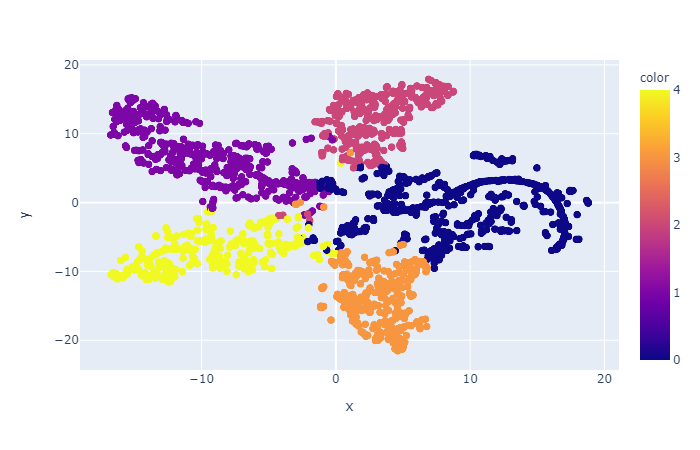

In [33]:
import plotly.express as px
fig = px.scatter(x=tsne_results[:,1], y=tsne_results[:,0], color=cats)#df['category'])
fig.show()

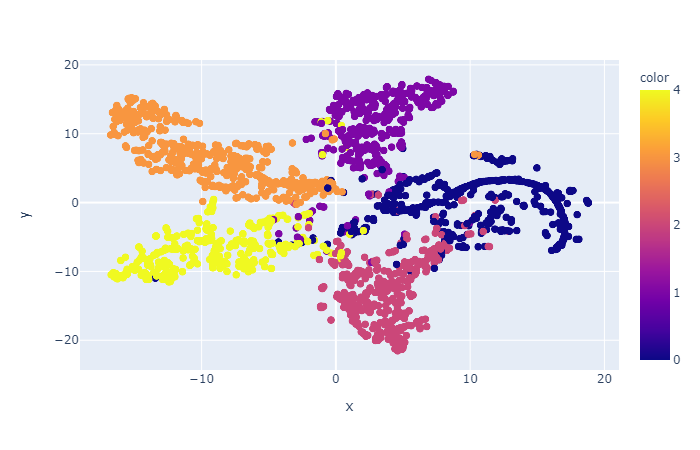

In [34]:
fig = px.scatter(x=tsne_results[:,1], y=tsne_results[:,0], color = df['category'].values)#, hover_data=df['text'].values)
fig.show()